In this lab, you will practice generative diffusion models on a synthetic dataset. You are supposed to do the following tasks.

1. Simulation of a stochastic differential equation.
1. Sampling from a target distribution using a generative diffusion model.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Setup
Let's first import the necessary libraries and set a random seed.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(666)

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 20})

# Problem formulation

Consider a target distribution

$$
\pi(x) = \sum_{i=1}^c w_i \, \mathrm{N}(x; m_i, V_i)
$$

which is a Gaussian mixture model with $c$ components for $m_i \in \mathbb{R}^d$ and $V_i \in \mathbb{R}^{d \times d}$.
Sampling from this distribution is trivial (which we will show how to do so later), but for now let us pretend that directly sampling from this distribution is difficult.
We will make use of a generative diffusion model to sample from this distribution.

# Noising and denoising processes
Recall the lecture note that a generative diffusion model consists of a pair of noising and denoising processes.

$$
\begin{equation}
    \begin{split}
        d X_t = a(X_t, t) d t + b(X_t, t) d W_t, \quad X_0 \sim \pi,
    \end{split}
    \tag{noising}
\end{equation}
$$

$$
\begin{equation}
    d X_t = a(X_t, t) - b(X_t, t) \, b(X_t, t)^\top \nabla\log p_t(X_t) d t + b(X_t, t) d W_t, \quad X_T \sim p_T,
    \tag{denoising}
\end{equation}
$$

The key observation is that sampling from $\pi$ is the same as simulating the denoising process starting from a sample $X_T \sim p_T$ and going back to $X_0$.
While directly sampling the target distribution may be difficulty, (approximately) simulating the denoising process can be much easier.
To achieve so, we follow the steps in the lecture note:

1. Design the noising process, that are, $a$ and $b$.
2. (̶T̶r̶a̶i̶n̶i̶n̶g̶)̶ D̶e̶s̶i̶g̶n̶ a̶ n̶e̶u̶r̶a̶l̶ n̶e̶t̶w̶o̶r̶k̶ ̶f̶o̶r̶ ̶p̶a̶r̶a̶m̶e̶t̶r̶i̶s̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶c̶o̶r̶e̶ ̶f̶u̶n̶c̶t̶i̶o̶n̶ ̶$\nabla\log p_t$.
3. (̶T̶r̶a̶i̶n̶i̶n̶g̶)̶ R̶u̶n̶ A̶l̶g̶o̶r̶i̶t̶h̶m̶ 2̶ t̶o̶ t̶r̶a̶i̶n̶ f̶o̶r̶ t̶h̶e̶ s̶c̶o̶r̶e̶ f̶u̶n̶c̶t̶i̶o̶n̶ $\nabla\log p_t$.
4. (Sampling) Run Algorithm 1 to simulate the denoising process.

Steps 2 and 3 aim to learn the score function $\nabla\log p_t$ with a neural network so that we can run Step 4. However, here we will rule out these two steps for 2 reasons: 1) training a neural network in this context requires a lot of engineering work but we don't have much lab time, and 2) we can exactly compute the score function $\nabla\log p_t$ for the considered target distribution, so we do not need to learn it. That is, imagine that someone has trained a perfect model without error and gave it to you.

We elaborate the remaining steps in the following sections.

# Define the target distribution and draw some samples to visualise it

Sampling from a Gaussian mixture is trivial. Let us define a two-dimensional Gaussian mixture model with randomly choisen means and covariance matrices, and then draw some samples from it to visualise the target distribution.

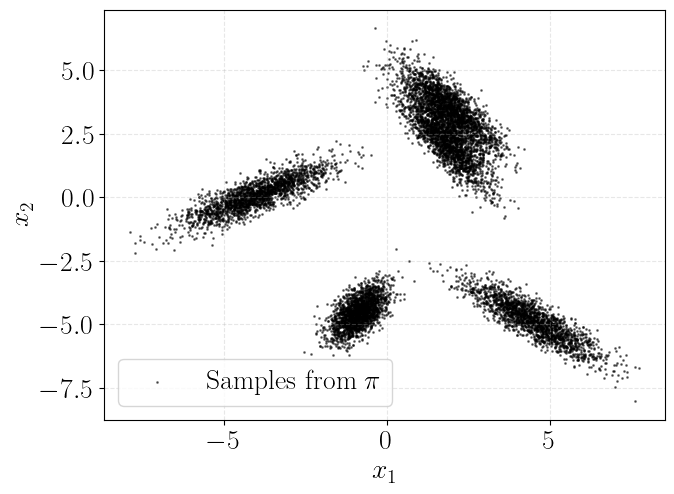

In [34]:
c = 5  # number of components
d = 2  # dimension of the target distribution
ws = np.ones(c) / c  # Gaussian mixture weights, assuming equal weights
ms = -5. + 10 * np.random.uniform(size=(c, d))  # Gaussian mixture means
_vs = np.random.randn(c, d)
vs = np.einsum('...i,...j->...ij', _vs, _vs) + np.eye(d) * 0.1  # Gaussian mixture covariance matrices


def target_sampler():
    """This function samples from a Gaussian mixture models
    """
    ind = np.random.choice(c, p=ws)  # choose a component according to the weights
    return ms[ind] + np.linalg.cholesky(vs[ind]) @ np.random.randn(d)  # sample from the chosen component


# Plot
nsamples = 10000
samples = np.zeros((nsamples, d))
for i in range(nsamples):
    samples[i] = target_sampler()

fig, ax = plt.subplots()
_ = ax.scatter(samples[:, 0], samples[:, 1], s=1, c='black', alpha=0.5, label=r'Samples from $\pi$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()
plt.tight_layout(pad=.1)
plt.show()

We can see that $\pi$ looks very non-Gaussian.

# Define the noising process

The noising process defines how the target $\pi$ diffuses in time.
For simplicity, let us choose $a(x) = -x$ and $b=\sqrt{2}$ as linear and $T=5$ so that the process diffuses the target to a standard Gaussian distribution in (infinite) time.
Moreover, we can exactly compute the distribution $p_t$ and its score function $\nabla\log p_t$.

## Task 1: simulating the noising process

To better understand the diffusing process, let us simulate the noising process using the Euler--Maruyama method (note that the noising process can be simulated exactly without the Euler approximation; this is only for pedagogy). Recall the noising process

$$
d X_t = a(X_t, t) d t + b(X_t, t) d W_t, \quad X_0 \sim \pi.
$$

The goal is to simulate a path $X_{0:N} = \lbrace X_0, X_1, \ldots, X_N \rbrace$ at times $0=t_0 < t_1 < \cdots < t_N=T$. This can be achieved approximately by Euler--Maruyama method:

Initialise $X_0 \sim \pi$, then for $k=1, 2, \ldots, N$ do:

1. $q_k \sim \mathrm{N}(0, I_d)$
2. $X_k \gets X_{k-1} + a(X_{k-1}, t_{k-1}) \, \Delta_k + b(X_{k-1}, t_{k-1}) \, \sqrt{\Delta_{k-1}} \, q_k $

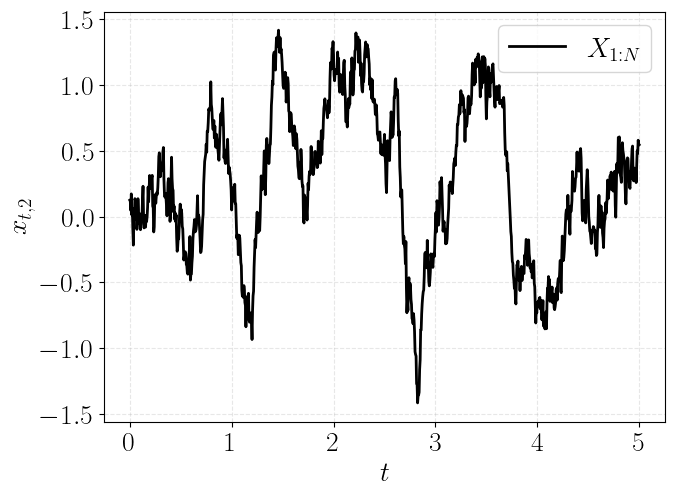

In [35]:
# Define the noising process parameters
def a(x, t):
    return -x


def b(x, t):
    return 2**0.5


# Choose a time grid for which we simulate the noising process
t0 = 0.  # initial time
T = 5.  # final time
nsteps = 1000  # number of time steps N
ts = np.linspace(t0, T, nsteps + 1)  # time steps
dt = T / nsteps  # time step size \Delta

# Simulate the noising process using Euler--Maruyama method
xs = np.zeros((nsteps + 1, d))  # a container for storing the path
xs[0] = target_sampler()
for k in range(1, nsteps + 1):
    q = np.random.randn(d)
    xs[k] = xs[k-1]+a(xs[k-1],ts[k-1])*dt + b(xs[k-1],ts[k-1])*np.sqrt(dt)*q

# Take a look at the simulated path
fig, ax = plt.subplots()
_ = ax.plot(ts, xs[:, 1], c='black', linewidth=2, label='$X_{1:N}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$x_{t, 2}$')
ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()
plt.tight_layout(pad=.1)

It might be hard to see what happens with only one path. Let us plot multiple paths to see the diffusion process more clearly.



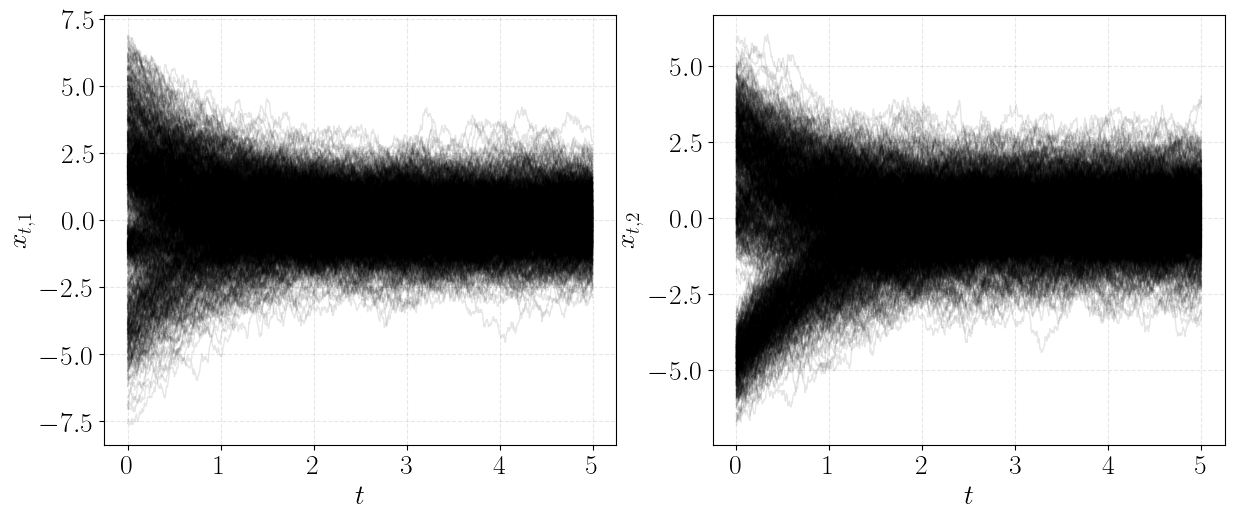

In [36]:
# In this cell, you draw npaths-number of independent paths of the noising process starting from independent initial samples
npaths = 1000
xs = np.zeros((npaths, nsteps + 1, d))  # a container for storing the path
for i in range(npaths):
    xs[i, 0] = target_sampler()
    for k in range(1, nsteps + 1):
        q = np.random.randn(d)
        xs[i, k] = xs[i,k-1]+a(xs[i,k-1],ts[k-1])*dt + b(xs[i,k-1],ts[k-1])*np.sqrt(dt)*q

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
for j in range(2):
    for i in range(npaths):
        _ = axes[j].plot(ts, xs[i, :, j], c='black', linewidth=1, alpha=.1)
    axes[j].set_xlabel('$t$')
    axes[j].set_ylabel('$x_{t, ' + f'{j + 1}' + '}$')
    axes[j].grid(linestyle='--', alpha=0.3, which='both')
plt.tight_layout(pad=.1)

We see that the paths "diffuses" to around zero despite that they initialised at different locations. We can also plot the marginal distributions $p_t$ for some $t$ to see this more clearly.

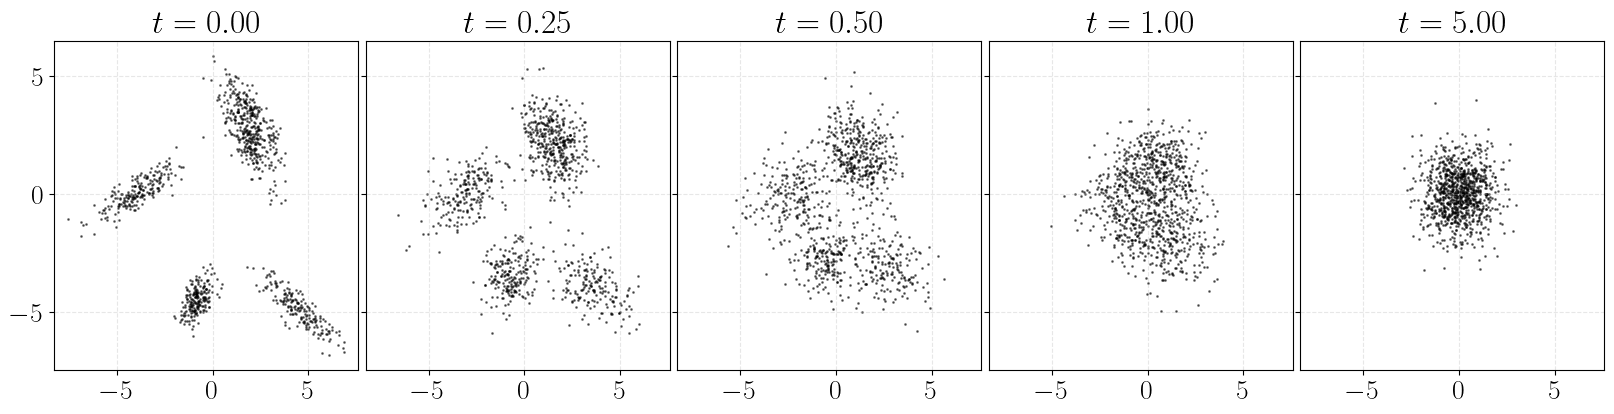

In [37]:
fig, axes = plt.subplots(ncols=5, sharey=True, sharex=True, figsize=(16, 4))

for ax, k in zip(axes, [0, 50, 100, 200, nsteps]):
    _ = ax.scatter(xs[:, k, 0], xs[:, k, 1], s=1, c='black', alpha=0.5, label='$p_{t_{k}}$')
    ax.set_title(f'$t = {ts[k]:.2f}$')
    ax.grid(linestyle='--', alpha=0.3, which='both')
plt.tight_layout(pad=.1)
plt.show()

You can clearly see that the noising process gradually noises $\pi$ into a standard Gaussian distribution as $t\to\infty$.

## Compute the score function

We have one last thing to do before we can sample from the target distribution using a generative diffusion model: compute the score function $\nabla\log p_t$.
Normally, this should be obtained by training a neural network, as the score function is mostly not analytically available.
However, in this case, we can compute it exactly.
The marginal distribution $p_t$ is again a Gaussian mixture for which we can compute its components's means and covariance matrices.

$$
\begin{equation}
    \begin{split}
        p_t(x) &= \sum_{i=1}^c w_i \, \mathrm{N}(x; m_{i,t}, V_{i,t}), \\
        m_{i, t} &= \exp(-(t - t_0)) \, m_i, \\
        V_{i, t} &= U_i \, D_{i, t} \, U_i^\top, \\
        D_{i, t} &= \exp(-2 \, (t - t_0))\, (D_i - I_d) + I_d
    \end{split}
\end{equation}
$$

where the eigendecomposition $V_i = U_i \, D_i \, U_i^\top$.
It might look a bit messy if implemented in Numpy. For simplicity, I have implemented this in JAX. You don't need to anything here but take a look at how it is implemented and run the code.

In [38]:
import jax
import jax.numpy as jnp
import math

jax.config.update('jax_enable_x64', True)

# Eigendecompositions of the covariance matrices
eigvals, eigvecs = jnp.linalg.eigh(vs)


def logpdf_mvn(x, m, eigvals, eigvecs):
    n = m.shape[0]
    res = x - m
    c_ = eigvecs.T @ res
    return -0.5 * (jnp.dot(c_, c_ / eigvals) + jnp.sum(jnp.log(eigvals)) + n * math.log(2 * math.pi))


def logpdf_kth(x, m, u, diag, t):
    _dt = t - t0
    pushfwd_m = jnp.exp(-_dt) * m
    pushfwd_d = jnp.exp(-2 * _dt) * (diag - 1) + 1
    return logpdf_mvn(x, pushfwd_m, pushfwd_d, u)


def logpdf(x, t):
    return jax.scipy.special.logsumexp(
        jax.vmap(logpdf_kth, in_axes=[None, 0, 0, 0, None])(x, ms, eigvecs, eigvals, t), b=ws)


@jax.jit
def _score(x, t):
    return jax.grad(logpdf)(x, t)


def score(x, t):
    return np.asarray(_score(x, t))

# Task 2: sampling from the target distribution using a generative diffusion model

With the score function $\nabla\log p_t$ available, we are now ready to sample from the target distribution using a generative diffusion model.
Recall the denoising process

$$
\begin{equation}
    d X_t = a(X_t, t) - b(X_t, t) \, b(X_t, t)^\top \nabla\log p_t(X_t) d t + b(X_t, t) d W_t, \quad X_T \sim p_T,
    \tag{denoising}
\end{equation}
$$

and take $p_T(x) \approx \mathrm{N}(x; 0, I_d)$. We can sample from $\pi$ by running the denoising process starting from $X_T \sim p_T$ and going back to $X_0$. Now take a look at Algorithm 1 in the lecture note, which is the sampling algorithm, and then implement it here.
However, note that Algorithm 1 has a small error. You are supposed to find this error and correct it in this implementation.

Suppose that we want to draw 1000 samples from $\pi$, then we need to simulate the denoising processes for 1000 times, independently.

In [39]:
nsamples = 1000
rev_xs = np.zeros((nsamples, nsteps + 1, d))  # a container for storing the reversal path
for i in range(nsamples):
    rev_xs[i, -1] = np.random.randn(d)  # sample from N(0, I_d)
    for k in reversed(range(1, nsteps + 1)):
        x_k = rev_xs[i, k]        # current (later) state
        t_k = ts[k]              # time for current state
        q = np.random.randn(d)

        drift = a(x_k, t_k) - b(x_k, t_k)**2 * score(x_k, t_k)
        diffusion = b(x_k, t_k)

        # step back: X_{k-1} = X_k - drift*dt + diffusion*sqrt(dt)*q
        rev_xs[i, k - 1] = x_k - drift * dt + diffusion * np.sqrt(dt) * q

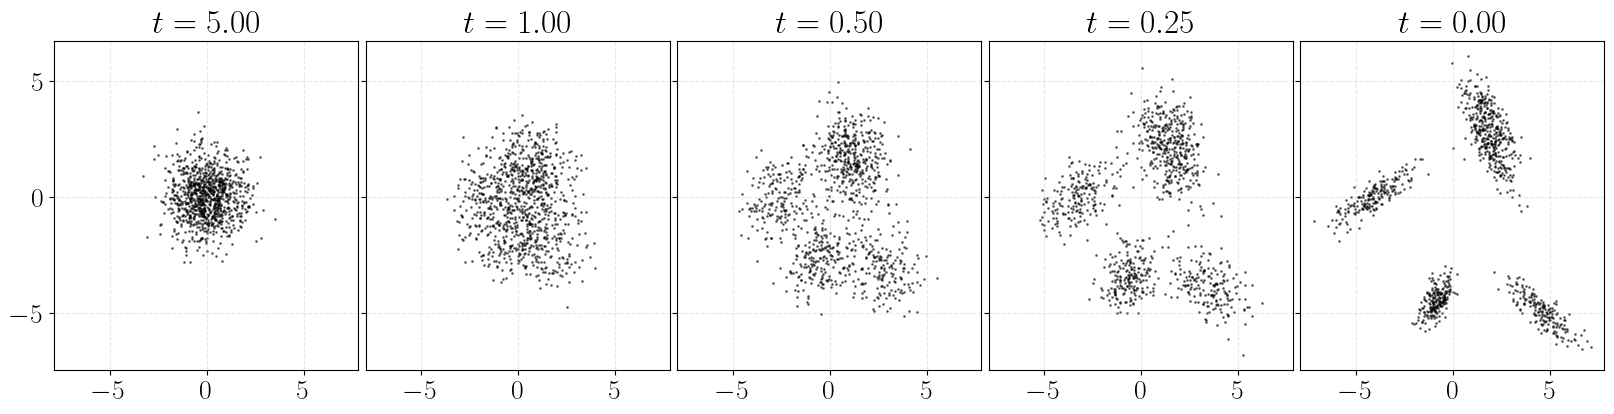

In [40]:
fig, axes = plt.subplots(ncols=5, sharey=True, sharex=True, figsize=(16, 4))

for i, k in enumerate([nsteps, 200, 100, 50, 0]):
    _ = axes[i].scatter(rev_xs[:, k, 0], rev_xs[:, k, 1], s=1, c='black', alpha=0.5, label='$p_{t_{k}}$')
    axes[i].set_title(f'$t = {ts[k]:.2f}$')
    axes[i].grid(linestyle='--', alpha=0.3, which='both')
plt.tight_layout(pad=.1)
plt.show()

You should see that the samples at $t_0$ should look very like from $\pi$.

# Contribution statement

If you have teamed up with someone, please write down the contribution of each team member in this cell. If you worked alone, you can leave this cell empty.

This assignment was completed as a team effort with equal contributions from Xiaochen and Nisal. Xiaochen is responsible for task 1, Nisal is responsible for task 2.
